In [1]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate()
#import Pkg; Pkg.activate(joinpath(@__DIR__,"..")); Pkg.instantiate()

  Activating environment at `~/.julia/dev/iLQGameSolver/examples/Project.toml`


In [2]:
using Revise
using LinearAlgebra
using Plots
using SparseArrays
using Random
using Test
using StaticArrays
using iLQGameSolver
using BenchmarkTools

┌ Info: Precompiling iLQGameSolver [894a8279-595f-4c20-8f0c-63b9232f715b]
└ @ Base loading.jl:1342
┌ Warning: Package iLQGameSolver does not have SparseArrays in its dependencies:
│ - If you have iLQGameSolver checked out for development and have
│   added SparseArrays as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with iLQGameSolver
└ Loading SparseArrays into iLQGameSolver from project dependency, future warnings for iLQGameSolver are suppressed.


### Quadcopter Nonlinear Dynamics

The states and inputs for the nonlinear quadcopter dynamics are defined as:

$$
\begin{equation}
x = [x, y, z, \dot{x}, \dot{y}, \dot{z}, \phi, \theta, \Psi]^{T} \\
\end{equation}
$$

$$
\begin{equation}
u = [\dot{z}_{cmd}, \phi_{cmd}, \theta_{cmd}, \dot{\Psi}_{cmd}]^{T}
\end{equation}
$$

And the nonlinear system model is defined by:

$$
\begin{equation}
\dot{x} = f(x(t), u(t)) = \begin{bmatrix}
           \dot{x} \\
           \dot{y} \\
           \dot{z} \\
           \ddot{x} \\
           \ddot{y} \\
           \ddot{z} \\
           \dot{\phi} \\
           \dot{\theta} \\
           \dot{\Psi} \\
         \end{bmatrix} = \begin{bmatrix}
           \dot{x} \\
           \dot{y} \\
           \dot{z} \\
           \frac{sin(\phi)sin(\Psi)+cos(\phi)sin(\theta)cos(\Psi)(\ddot{z}+g)}{cos(\theta)cos(\phi)} \\
           \frac{-sin(\phi)sin(\Psi)+cos(\phi)sin(\theta)sin(\Psi)(\ddot{z}+g)}{cos(\theta)cos(\phi)} \\
           \frac{1}{\tau_{z}} (\dot{z}_{cmd} - \dot{z}) \\
           \frac{1}{\tau_{\phi}} (\phi_{cmd} - \phi) \\
           \frac{1}{\tau{}_{\theta}} (\theta_{cmd} - \theta) \\
           \dot{\Psi}_{cmd} \\
         \end{bmatrix}
\end{equation}
$$


In [3]:
# Setup the problem

dt = 0.1                    # Step size [s]
tf = 30.0                    # Horizon [s]
N = Int(tf/dt)         # Number of steps (knot points)

# Define cost matrices 
nx = 9 
nu = 4
Nplayer = 2

Nu = nu * Nplayer
Nx = nx * Nplayer

Q1 = sparse(zeros(Nx,Nx))     # State cost for agent 1
Q1[1:nx,1:nx] .= 3.0*I(nx)
Qn1 = Q1                    # Terminal cost for agent 1

Q2 = sparse(zeros(Nx,Nx))     # State cost for agent 2
Q2[nx+1:2*nx,nx+1:2*nx] .= 3.0*I(nx)
Qn2 = Q2                    # Terminal cost for agent 2

R11 = sparse(1.0*I(nu))              # Control cost for player 1
R12 = sparse(0.0*I(nu))     # Control cost for player 1 associated with player 2's controls

R21 = sparse(0.0*I(nu))     # Control cost for player 2 associated with player 1's controls
R22 = sparse(1.0*I(nu))              # Contorl cost for player 2


dmax = 2.0                  # Distance that both agents should keep between each other [m]
ρ = 500.0                   # Penalty factor for violating the distance constraint

# Q's are stacked vertically
Q = sparse(zeros(Float32, Nx*Nplayer, Nx))
# @show size([Q1; Q2; Q3]), size(Q)
#Q .= [Q1; Q2]
Q .= [Q1; Q2]

# Qn's are stacked vertically
Qn = sparse(zeros(Float32, Nx*Nplayer, Nx))
#Qn .= [Qn1; Qn2]
Qn .= [Qn1; Qn2]

# R's are stacked as a matrix
R = sparse(zeros(Float32, Nu, Nu))
#R .= [R11 R12; R21 R22]
R .= [R11 R12; R21 R22]

NHor = 25
tol = 1e-2

game = iLQGameSolver.GameSetup(nx, nu, Nplayer, Q, R, Qn, dt, tf, NHor, dmax, ρ, tol)

solver = iLQGameSolver.iLQSetup(Nx, Nu, Nplayer, NHor)

solver.P = ones(NHor, Nu, Nx)*0.001
solver.α = ones(NHor, Nu)*0.001;

In [4]:
# Initial and final states

x₀= [5.0; 5.0; 5.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 
    -5.0; -5.0; 5.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0]        # Initial state

xgoal = [  -5.0; -5.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 
            5.0; 5.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0];  # Final state

# Input constraints
umax = [10.0, pi, pi, pi, 
        10.0, pi, pi, pi]   

umin = [-10.0, -pi, -pi, -pi, 
        -10.0, -pi, -pi, -pi] 

ugoal = [0.0, 0.0, 0.0, 0.0,
        0.0, 0.0, 0.0, 0.0]     

game.x0 .= x₀
game.xf .= xgoal
game.umin .= umin
game.umax .= umax
game.uf .= ugoal;

In [66]:
X, U = iLQGameSolver.recedingHorizon(game, solver, iLQGameSolver.quadcopter, iLQGameSolver.costQuadcopter);

Controller ran at 13.285460572021114 Hz


In [6]:
X[end,:,:]

18×1 Matrix{Float64}:
 -4.9824138823282675
 -5.517794925867701
 -5.5826004794257e-6
  0.00024100891258299362
 -0.007120912433709175
  1.6126564055522147e-9
 -0.007185630549729582
  3.133120186454012e-6
  0.008363072538533897
  4.982413725322208
  5.517797566167199
 -5.582508752996887e-6
 -0.00024101526493847857
  0.007121032746753151
  1.6122884942717403e-9
  0.00718572377467748
 -3.133289153097872e-6
  0.008363188149984916

In [7]:
xend = X[end,:,:]

@test xend[1] ≈ xgoal[1] atol=1e-1 
@test xend[2] ≈ xgoal[2] atol=1e0 
@test xend[3] ≈ xgoal[3] atol=1e-1 
@test xend[4] ≈ xgoal[4] atol=1e-1 
@test xend[5] ≈ xgoal[5] atol=1e-1 
@test xend[6] ≈ xgoal[6] atol=1e-1 
@test xend[7] ≈ xgoal[7] atol=1e-1 
@test xend[8] ≈ xgoal[8] atol=1e-1 
@test xend[9] ≈ xgoal[9] atol=1e0 
@test xend[10] ≈ xgoal[10] atol=1e-1 
@test xend[11] ≈ xgoal[11] atol=1e0 
@test xend[12] ≈ xgoal[12] atol=1e-1 

Test Passed

┌ Info: Saved animation to /home/ahmed/.julia/dev/iLQGameSolver/examples/assets/gifs/quadcopter.gif
└ @ Plots /home/ahmed/.julia/packages/Plots/Pn7Zn/src/animation.jl:149


Plots.AnimatedGif("/home/ahmed/.julia/dev/iLQGameSolver/examples/assets/gifs/quadcopter.gif")
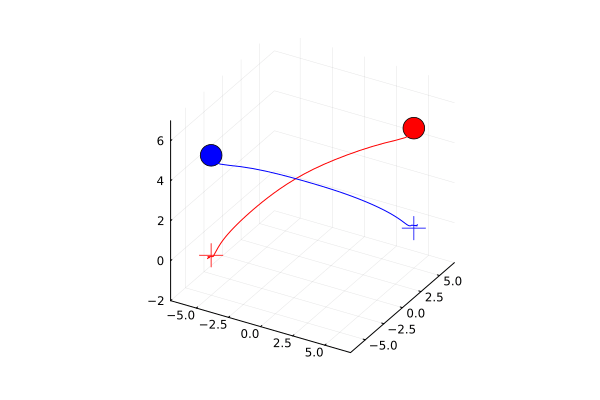

In [47]:
anim = @animate for t in 1:N
    scatter3d([X[t,1,:]], [X[t,2,:]], [X[t,3,:]], m = (:circle, 12),
    xlims = (-7, 7), 
    ylims = (-7, 7), 
    zlims = (-2, 7),
    legend = false, color="red")
    scatter3d!([X[t,10,:]], [X[t,11,:]], [X[t,12,:]], m = (:circle, 12), color="blue")
    plot3d!(X[:,1], X[:,2], X[:,3], color = "red")
    plot3d!(X[:,10], X[:,11], X[:,12], color = "blue")
    plot3d!([xgoal[1]], [xgoal[2]], [xgoal[3]], m = (:cross, 12, :red))
    plot3d!([xgoal[10]], [xgoal[11]], [xgoal[12]], m = (:cross, 12, :blue))

end every 1;
gif(anim, "assets/gifs/quadcopter.gif")

In [64]:
t = 100

scatter([X[t,1,:]], [X[t,2,:]], m = (:circle, 12),
    xlims = (-7, 7), 
    ylims = (-7, 7),
    legend = false, color="red")
scatter!([X[t,10,:]], [X[t,11,:]], m = (:circle, 12), color="blue")
plot!(X[:,1], X[:,2], legend=false, color="red", xaxis = false, yaxis=false)
plot!(X[:,10], X[:,11], color="blue")
plot!([xgoal[1]], [xgoal[2]], m = (:cross, 12, :red))
plot!([xgoal[10]], [xgoal[11]], m = (:cross, 12, :blue))

savefig("assets/imgs/quadcopter2D$t")

scatter3d([X[t,1,:]], [X[t,2,:]], [X[t,3,:]], m = (:circle, 12),
    xlims = (-7, 7), 
    ylims = (-7, 7),
    legend = false, color="red")
scatter3d!([X[t,10,:]], [X[t,11,:]], [X[t,12,:]], m = (:circle, 12), color="blue")
plot3d!(X[:,1], X[:,2], X[:,3], color = "red", legend=false)
plot3d!(X[:,10], X[:,11], X[:,12], color = "blue")
plot!([xgoal[1]], [xgoal[2]],[xgoal[3]], m = (:cross, 12, :red))
plot!([xgoal[10]], [xgoal[11]], [xgoal[12]],m = (:cross, 12, :blue))
savefig("assets/imgs/quadcopter3D$t")


"/home/ahmed/.julia/dev/iLQGameSolver/examples/assets/imgs/quadcopter3D100.png"

"/home/ahmed/.julia/dev/iLQGameSolver/examples/assets/imgs/quadcopter3D1.png"

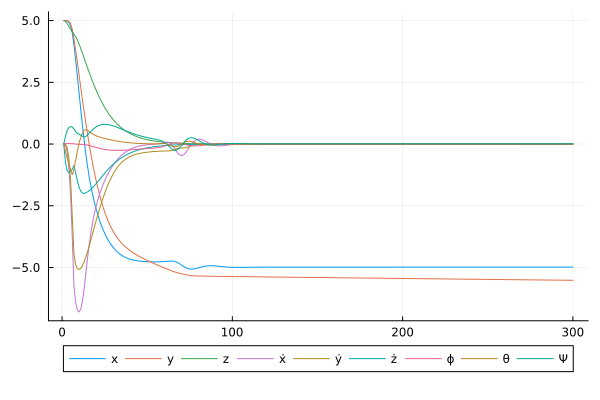

In [42]:
# Plot of all states for agent 1

plot([X[:,1:9]], 
    label=["x" "y" "z" "ẋ" "ẏ" "ż" "ϕ" "θ" "Ψ"],
    legend=:outerbottom, 
    legendcolumns=9)

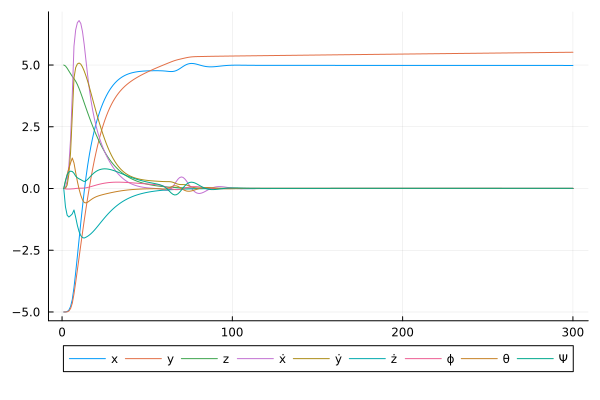

In [43]:
# Plot of all states for agent 2

plot([X[:,10:18]], 
    label=["x" "y" "z" "ẋ" "ẏ" "ż" "ϕ" "θ" "Ψ"],
    legend=:outerbottom, 
    legendcolumns=9)